## **MuonBatch._hits has NaNs**


As demonstrated at the end of `muon_prop_through_hodoscopes.ipynb` notebook, **`ScatterBatch`** has **no hits** to use when using the overlap hodoscope configuration.

First, let's try an example witrh a `simple` detector configuration. 

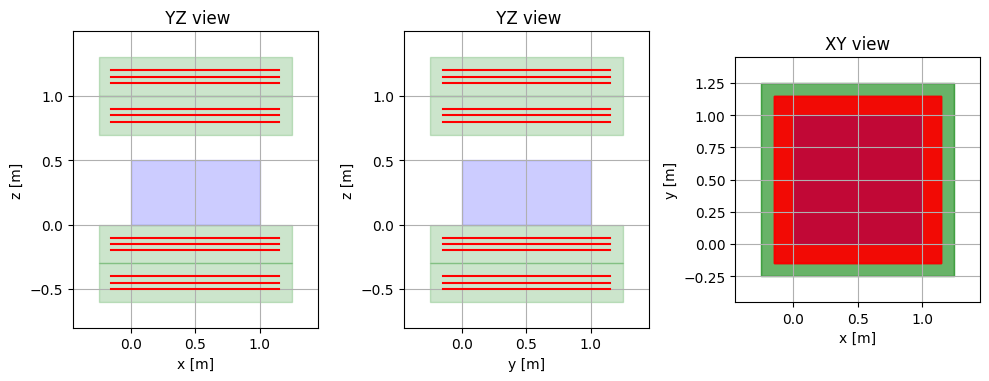

In [1]:
# Create the volume
from volume.hodoscope_init_config import get_standard_hod_config
volume = get_standard_hod_config()

# Draw volume
from plotting.plotting import draw_volume_2D
draw_volume_2D(volume)

Now, let's include the detector configuration in the volume's **wapper**. It is handled bby the hodoscopeVolumeWrapper class.

In [2]:
from optimisation.hodoscope_volume_wrapper import HodoscopeVolumeWrapper
from functools import partial
from tomopt.optimisation import VoxelX0Loss

import torch

wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

Now we create a passive volume made of **water** and **lead**.

In [3]:
from tomopt.core import X0
from torch import Tensor

def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['water']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

from tomopt.optimisation import PassiveYielder
passives = PassiveYielder([arb_rad_length,arb_rad_length], shuffle=True)

In [4]:
from tomopt.optimisation.callbacks import MuonResampler, ScatterRecord, HitRecord
from tomopt.optimisation import PredHandler, ScatterRecord, HitRecord, ScatterAngleRecord

In [5]:
sr = ScatterRecord()
hr = HitRecord()
preds = wrapper.predict(PassiveYielder([arb_rad_length]), 
                        n_mu_per_volume=2000, 
                        mu_bs=500, 
                        pred_cb=PredHandler(), 
                        cbs=[MuonResampler(), sr, hr])

Using the `ScatterRecord` and `HitRecord` callbacks, we can take a look at the generated and recorded hits.

`HitRecord` records the hit locations.

In [6]:
hits = hr.get_record(True)

for col in hits.columns:
    print("{} feature has NaNs ? {}".format(col, hits[col].isnull().any()))

x feature has NaNs ? False
y feature has NaNs ? False
z feature has NaNs ? False
layer feature has NaNs ? False


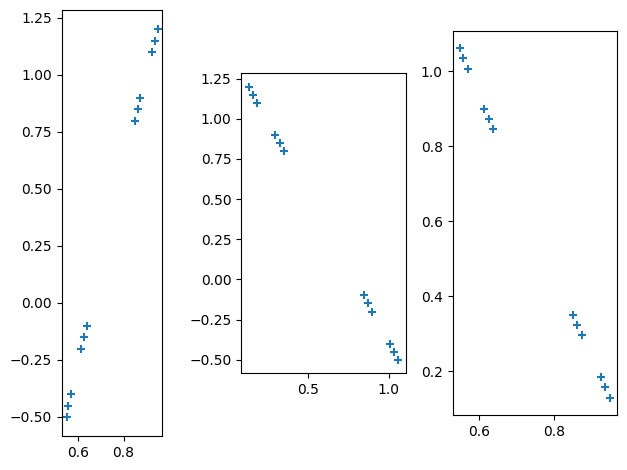

In [7]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(ncols=3)
event = np.random.randint(100)
hits = hr.get_record()

axs[0].scatter(hits[event, :, 0].detach().numpy(), hits[event, :, 2].detach().numpy(), marker = "+")
axs[1].scatter(hits[event, :, 1].detach().numpy(), hits[event, :, 2].detach().numpy(), marker = "+")
axs[2].scatter(hits[event, :, 0].detach().numpy(), hits[event, :, 1].detach().numpy(), marker = "+")
for ax in axs:
    ax.set_aspect("equal")
plt.tight_layout()
plt.show()

Sor far, everything seems to be fine. No NaNs nor strange values in the reconstructed hits.

Let's have a look at `ScatterRecord`, which records the scattering locations a.k.a the POCA points.


In [8]:
pocas = sr.get_record(True)

for col in pocas.columns:
    print("{} feature has NaNs ? {}".format(col, pocas[col].isnull().any()))

print("Layer feature of hits has {} NaNs over {} entries".format(pocas.layer.isnull().sum(), len(pocas)))

x feature has NaNs ? False
y feature has NaNs ? False
z feature has NaNs ? False
layer feature has NaNs ? False
Layer feature of hits has 0 NaNs over 365 entries


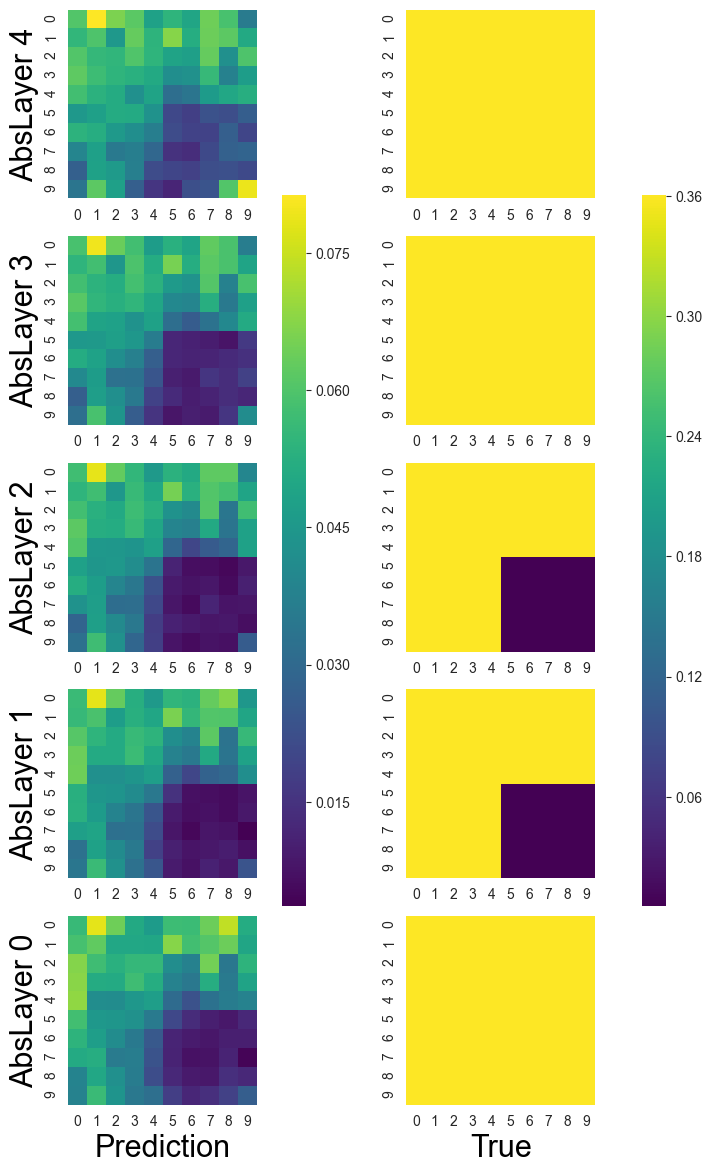

In [9]:
from tomopt.plotting import plot_pred_true_x0
plot_pred_true_x0(preds[0][0], preds[0][1])

So far, everything seems to be running smoothly. Let's try to run `wrapper.predict` for a different detector configuration, with a slight overlap in $xy$ but not along $z$.

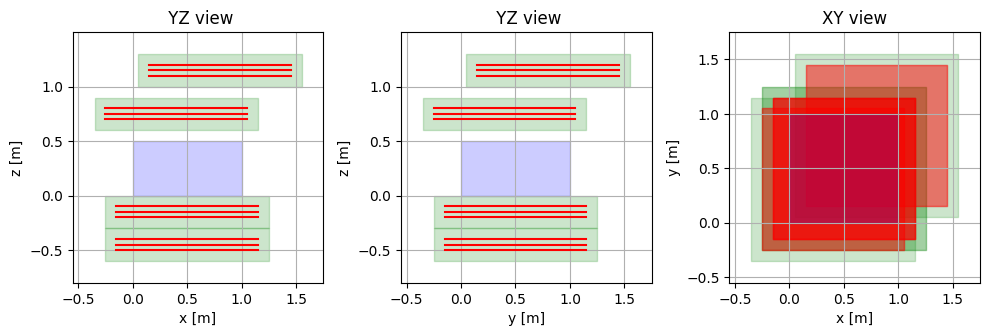

In [10]:
# Create the volume
from volume.hodoscope_init_config import get_half_overlap_hod_config
volume = get_half_overlap_hod_config()

# Draw volume
from plotting.plotting import draw_volume_2D
draw_volume_2D(volume)

# Set up wrapper
wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

# Set up wrapper
sr = ScatterRecord()
hr = HitRecord()
sar = ScatterAngleRecord()

# Run predictions
preds = wrapper.predict(PassiveYielder([arb_rad_length]), 
                        n_mu_per_volume=2000, 
                        mu_bs=500, 
                        pred_cb=PredHandler(), 
                        cbs=[MuonResampler(), sr, hr, sar])

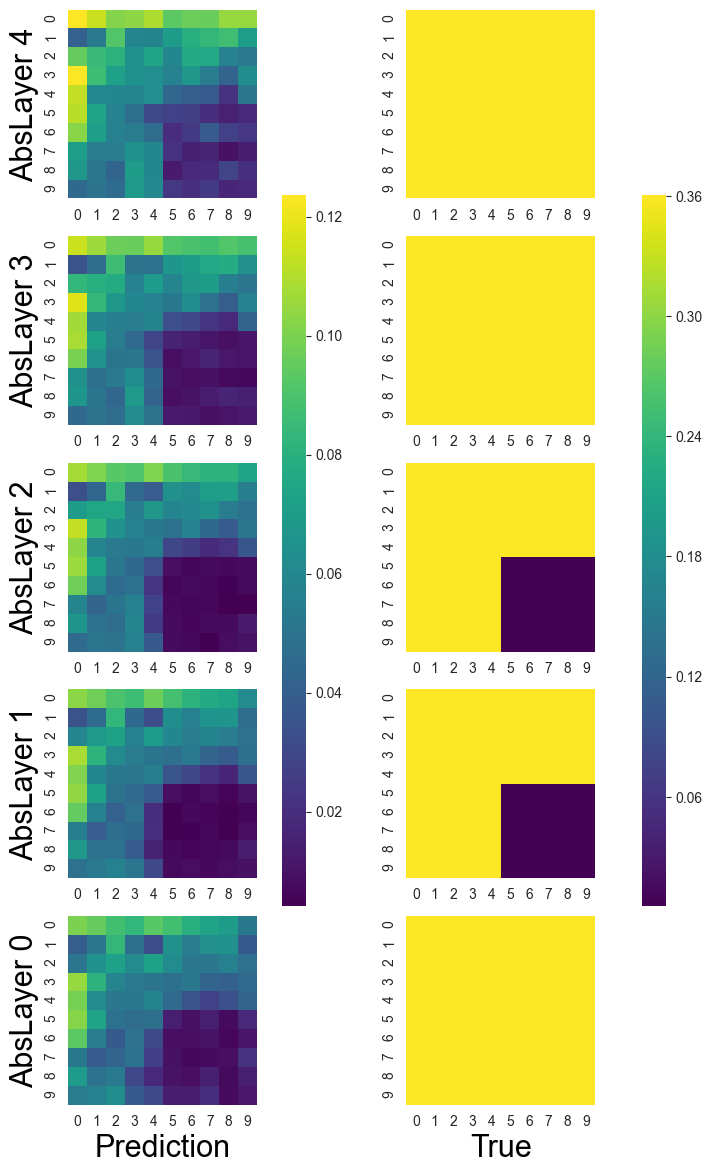

In [11]:
plot_pred_true_x0(preds[0][0], preds[0][1])

Again predictions are fine. Let's move on to a configuration with overlap in $z$.

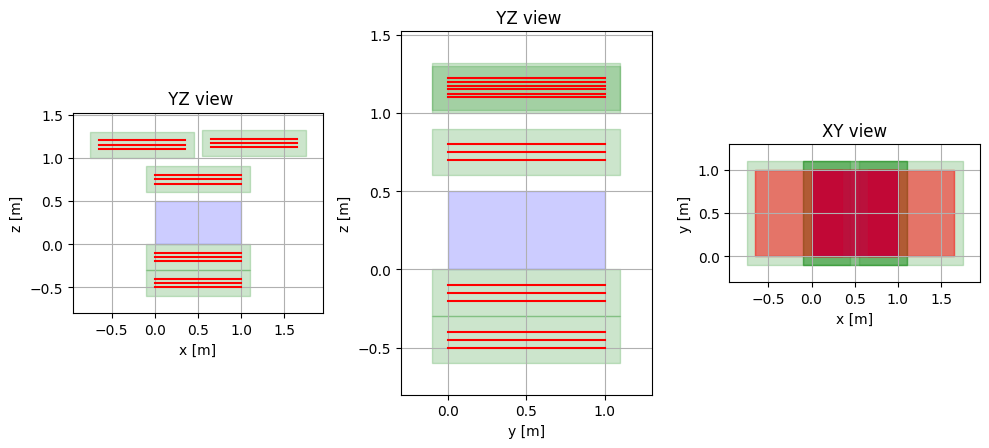

In [12]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from tomopt.volume.layer import PassiveLayer
from tomopt.core import DEVICE
from tomopt.volume import Volume
from torch import nn

def get_z_overlap_hod_config() -> Volume:

    init_xyz_span, xyz_gap = [1.2, 1.2, .3], [.1, .1, .1]
    init_eff, init_res = 0.90, 1e5

    hods = [Hodoscope(init_xyz= [0.5, 0.5, .9], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res), 
            Hodoscope(init_xyz= [1.15, .5, 1.32], 
            init_xyz_span = init_xyz_span, 
            xyz_gap = xyz_gap, 
            eff = init_eff,
            res = init_res), 
                      Hodoscope(init_xyz= [-.15, .5, 1.3], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res),
                      ]
                    #  ) for xy, z in zip([0.4, 0.8], [.9, 1.3])]

    hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                                lw = Tensor([2,2]), 
                                                z = 1., size = 0.5, 
                                                hodoscopes = hods)

    hods = [Hodoscope(init_xyz= [.5, .5, z], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res
                     ) for z in [0.0,-0.3]]
    
    hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                                lw = Tensor([1,1]), 
                                                z = 1., size = 0.5, 
                                                hodoscopes = hods)

    def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1,1,1])
        size = 0.1
        
        layers.append(hod_layers[0])
        for z in [0.7,0.6,0.5,0.4,0.3]:
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
        layers.append(hod_layers[1])

        return nn.ModuleList(layers)
    
    return Volume(get_layers([hod_detector_above, hod_detector_below]))

# Create the volume
volume = get_z_overlap_hod_config()

# Draw volume
from plotting.plotting import draw_volume_2D
draw_volume_2D(volume)

In [13]:
# Set up wrapper
wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))

# Set up wrapper
sr = ScatterRecord()
hr = HitRecord()
sar = ScatterAngleRecord()

# Run predictions
preds = wrapper.predict(PassiveYielder([arb_rad_length]), 
                        n_mu_per_volume=2000, 
                        mu_bs=500, 
                        pred_cb=PredHandler(), 
                        cbs=[MuonResampler(), sr, hr, sar])

TypeError: nan_to_num(): argument 'input' (position 1) must be Tensor, not NoneType

The error happens when there is an overlap in $z$. Let's manually run the `wrapper.predict` method which basicaly does:

```python
    self.fit_params = FitParams(
                n_mu_per_volume=n_mu_per_volume,
                mu_bs=mu_bs,
                cbs=cbs,
                tst_passives=passives,
                state="test",
                cb_savepath=cb_savepath,
                device=self.device,
            )

    self._scan_volumes(self.fit_params.tst_passives)

return pred_cb.get_preds()
```

With `_scan_volumes` defined as:

```python
self.volume.load_rad_length(passive, target)
self._scan_volume()
```

and `_scan_volumes` defined as:
```python

muon_bar = progress_bar(range(self.fit_params.n_mu_per_volume // self.fit_params.mu_bs))
for _ in muon_bar:
    self.fit_params.mu = MuonBatch(self.mu_generator(self.fit_params.mu_bs), init_z=self.volume.h, device=self.fit_params.device)
    # On muon batch begin
    self.volume(self.fit_params.mu)
    self.fit_params.sb = self.partial_scatter_inferrer(mu=self.fit_params.mu, volume=self.volume)
    # On scatter end
    self.fit_params.volume_inferrer.add_scatters(self.fit_params.sb)
    # On muon batch end

self.fit_params.pred = self.fit_params.volume_inferrer.get_prediction()
```



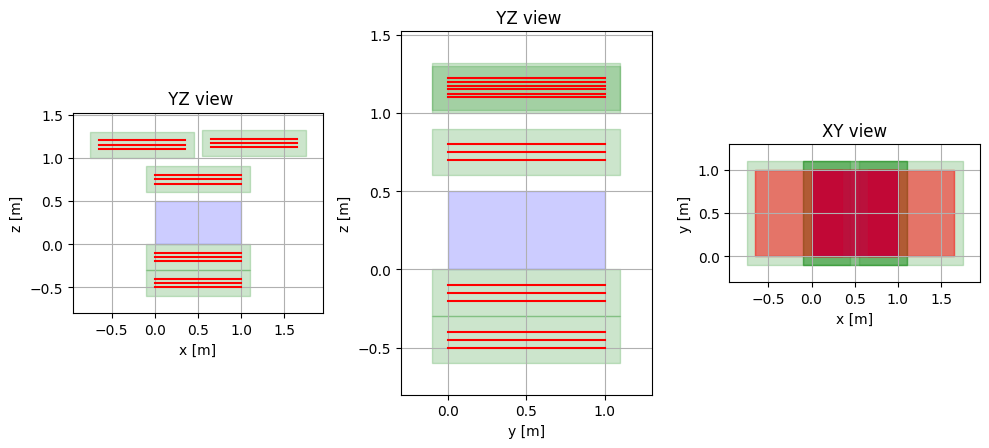

In [23]:
# Create the volume
volume = get_z_overlap_hod_config()

# Plot volume
draw_volume_2D(volume)

# Load radiation length
volume.load_rad_length(arb_rad_length)

from tomopt.muon import MuonGenerator2016, MuonBatch
from tomopt.inference.scattering import ScatterBatch


n_muons, batch_size = 10000, 500
scatter_batches = []
from fastprogress import progress_bar
muon_bar = progress_bar(range(n_muons // batch_size))

for _ in muon_bar:

    # generate muons
    gen = MuonGenerator2016(x_range=[0.,1.], y_range=[0.,1.], theta_range=[0.001, 0.2], energy_range=[1.,4.])
    muons = MuonBatch(xy_p_theta_phi=gen.generate_set(batch_size), init_z = 1.5)

    # Propagate muons
    volume(muons)

    # Get ScatterBatch
    scatter_batches.append(ScatterBatch(mu = muons, volume = volume))

In [24]:
# Set up the radiation length inferrer
from tomopt.inference.volume import PanelX0Inferrer
partial_volume_inferrer = PanelX0Inferrer(volume = volume)

# Load each ScatterBatch in the volume inferrer
for sb in scatter_batches:
    partial_volume_inferrer.add_scatters(sb)

In [26]:
scatter_batches[0]._gen_hits.size()

torch.Size([487, 15, 3])

It appears that `ScatterBatch` has recorded hits!

In [30]:
preds = partial_volume_inferrer.get_prediction()

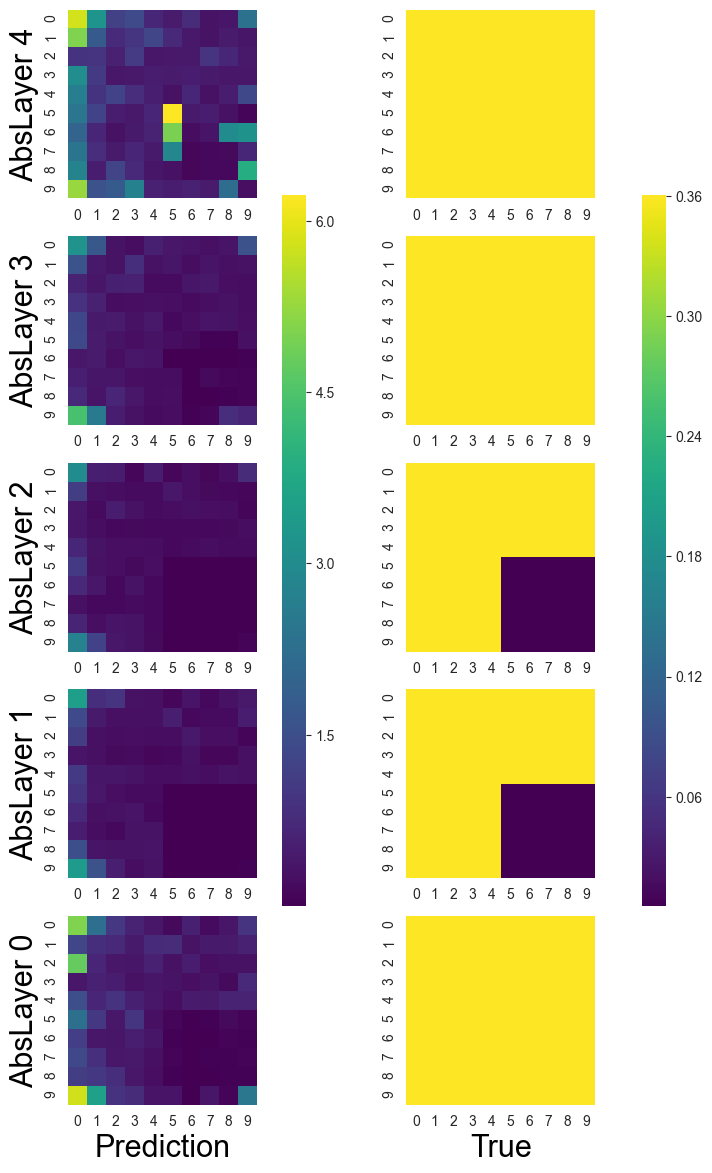

In [35]:
# Plot the predictions
from tomopt.plotting import plot_pred_true_x0
plot_pred_true_x0(preds.detach().numpy(), volume.get_rad_cube().detach().cpu().numpy())

When run manually, everything seems to be fine! Instead of plotting the predictions, it might be easier to plot the poca points for now.

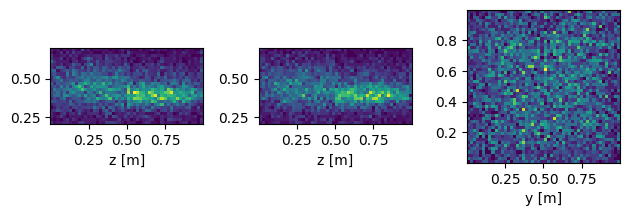

In [36]:
pocas = partial_volume_inferrer.muon_poca_xyz

z = volume.get_passive_z_range()
mask_in = (
    (pocas[:, 0] >= 0)
    * (pocas[:, 0] < volume.lw[0])
    * (pocas[:, 1] >= 0)
    * (pocas[:, 1] < volume.lw[1])
    * (pocas[:, 2] >= z[0])
    * (pocas[:, 2] < z[1])
)

pocas_in = pocas[mask_in].detach().numpy()

from plotting.plotting import plot_poca_points
plot_poca_points(pocas=pocas_in, binning_xyz=(50, 50, 25))

Let's have a look at the `ScatterBatch` hits:

In [37]:
gen_hits = torch.cat([sb._gen_hits for sb in scatter_batches], dim=0)
reco_hits = torch.cat([sb._reco_hits for sb in scatter_batches], dim=0)

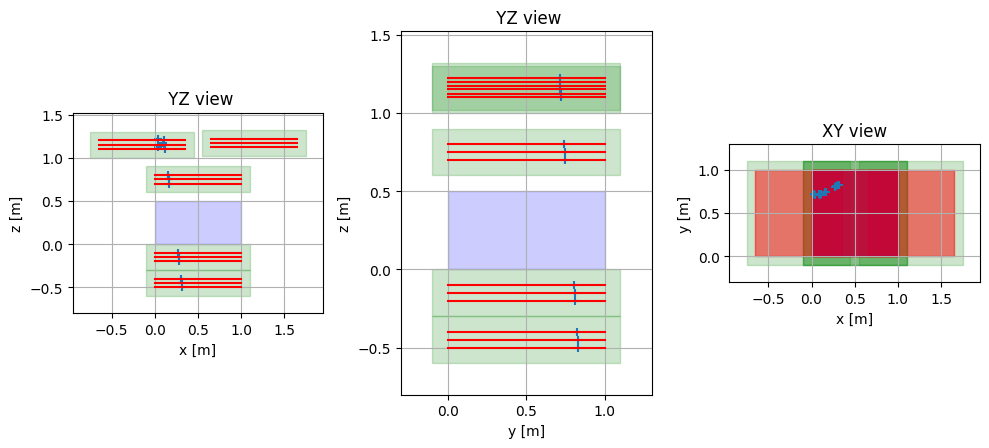

In [38]:
from plotting.plotting import draw_volume_2D

draw_volume_2D(volume, hits = reco_hits, event = 10)

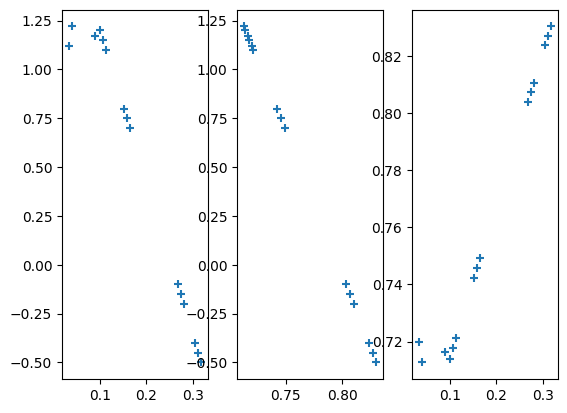

In [39]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=3)
event = 10
hits = reco_hits

axs[0].scatter(hits[event, :, 0].detach().numpy(), hits[event, :, 2].detach().numpy(), marker = "+")
axs[1].scatter(hits[event, :, 1].detach().numpy(), hits[event, :, 2].detach().numpy(), marker = "+")
axs[2].scatter(hits[event, :, 0].detach().numpy(), hits[event, :, 1].detach().numpy(), marker = "+")
plt.show()